## Introduction

Sample Text

In [4]:
# Just import commands.
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import geopandas
%matplotlib inline

 ----- Yuqing -----

----- Nafee -----

----- Kenny -----

----- Anderis -----

Pittsburgh is a pretty large city. Despite all the high rises and parking complexes, there are still quite a lot of trees throughout each neighborhood of the city. For my part of the Project I am going to be looking at the number of (legally documented and cared for) trees that are within each neighborhood. Throughout this file will have information on the numerics of these trees, as well as their general wellbeing. All of these factors will go into my metric to decide which neighborhood is truly the best in Pittsburgh. (based on this arbitrary metric :D).

<AxesSubplot:>

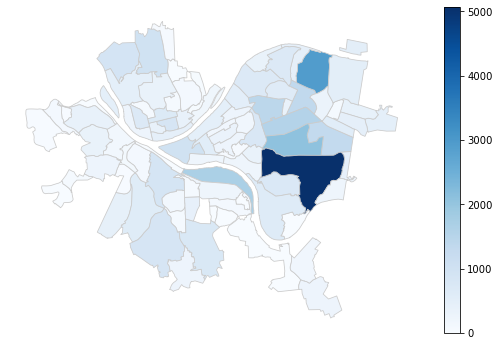

In [5]:
# Initializing datasets and changing some of the indexes to better fit my needs
trees    = pd.read_csv('Datasets\Trees.csv', low_memory=False)
fname    = "Datasets/Neighborhoods.geojson"
pitt_map = geopandas.read_file(fname)
pitt_map = pitt_map.rename(columns={'Neighborhood_2010_HOOD' : 'Neighborhood'})
df       = pd.DataFrame(data=trees['neighborhood'].value_counts(sort=False))
df       = df.rename(columns={'neighborhood' : 'count'}).reset_index()
df       = df.rename(columns={'index' : 'neighborhood'})

# Sorted both datasets so they would match up
pitt_map = pitt_map.sort_values(by='Neighborhood').reset_index()
df       = df.sort_values(by='neighborhood').reset_index()

# merges the two data sets together with a concatination.
frame    = [pitt_map,df]
merged   = pd.concat(frame, axis=1, ignore_index=False, sort=False)

# general variables to help setup the Choropleth map
variable   = 'count'
vmin, vmax = 0, 5073
fig, ax    = plt.subplots(1, figsize=(10, 6))

# turns off the axis lines
ax.axis('off')

# sets up the legend for the map
sm   = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# writes the map
merged.plot(column=variable, cmap='Blues', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

This is the first of my Choropleth maps!

This one is quite simple, it just maps out all the different neighborhoods and colors them in based on total number of trees within the neighborhood. Obviously Squirrel Hilll South, the largest neighborhood, is top of the list on this one.

In [6]:
# Lists out the neighborhoods with the top 10 highest tree counts.
merged[['neighborhood','count']].sort_values(by='count', ascending=False).head(10)

,neighborhood,count
76,Squirrel Hill South,5073
39,Highland Park,2941
75,Squirrel Hill North,2083
71,South Side Flats,1693
67,Shadyside,1558
9,Bloomfield,1436
28,East Liberty,1366
62,Point Breeze,1316
60,Perry North,1007
16,Central Business District,1002


Now do we get all the information we want from that map? of course not! Obviously the alrgest neighborhood has the most amount of trees. So lets try incorporating the areas of the neighborhoods into the calculations!

<AxesSubplot:>

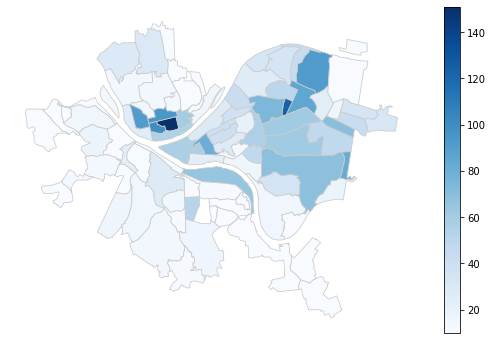

In [7]:
# Calculates the amount of trees per square kilometer within each neighborhood
TSK = (merged['count']).div(merged['SHAPE_Area'].mul(100000)).to_frame('Trees per Square Kilometer')

# Concatinates the datasets. Be prepared for lots of mergedx variables.. I'm not the best at naming :D
merged2 = pd.concat([merged, TSK], axis=1, ignore_index=False, sort=False)

# once again just variable stuff for the map
variable = 'Trees per Square Kilometer'
vmin,vmax = 10, 151
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# legend stuff
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# draws out the map
merged2.plot(column=variable, cmap='Blues', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

Now the map is looking a lot different! accounting for the total number of trees mixed with the area has made it so Allegheny Center, a decently small neighborhood, is shown to have the highest density of trees per square kilometer. In fact Squirrel Hill, our highest before, does not even fall into the top 10 now.

In [8]:
merged2[['neighborhood','Trees per Square Kilometer']].sort_values(by='Trees per Square Kilometer', ascending=False).head(10)

,neighborhood,Trees per Square Kilometer
0,Allegheny Center,150.730121
33,Friendship,123.953330
1,Allegheny West,99.357446
18,Central Northside,94.641829
48,Manchester,92.052254
39,Highland Park,91.936289
28,East Liberty,85.460371
65,Regent Square,82.097723
23,Crawford-Roberts,79.950480
9,Bloomfield,74.367717


Our new top 10 has a lot of smaller neighborhoods starting to gain in spots. Of course not every tree is created equal. So how do all of these neighborhoods fair when the health of the trees are a concern?

The beginning of this next section of code uses the conditions of the trees in order to calulate a total number of healthy trees. I used a scoring system from Dead equaling -2 trees, all the way up to Excellent equalling 1.4 trees. This way neighborhoods that take more care of their trees gain more of an advantage.

<AxesSubplot:>

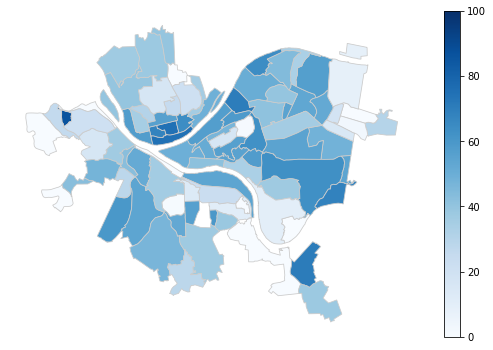

In [9]:
# list to hold the condition values.
cond_list = []

# code to ammend a list with all the values based on condition of the trees.
for x in trees['condition']:
    if x != x:
        cond_list.append(-1)
    elif x == 'Dead':
        cond_list.append(-2)
    elif x == 'Critical':
        cond_list.append(0.2)
    elif x == 'Poor':
        cond_list.append(0.4)
    elif x == 'Fair':
        cond_list.append(0.6)
    elif x == 'Good':
        cond_list.append(1.0)
    elif x == 'Very Good':
        cond_list.append(1.2)
    elif x == 'Excellent':
        cond_list.append(1.4)
    else:
        cond_list.append(x)

# adding the values into a DataFrame
cond_val = pd.DataFrame().append(cond_list)
cond_val.columns = ['Tree Health']

# merging the dataframe into the Tree.csv file DataFrame
tree_merge = pd.concat([trees,cond_val], axis=1, ignore_index=False, sort=False)

# groups all of the different values based on the neighborhood they reside and sums the scores together.
tree_health = tree_merge.groupby(by='neighborhood').sum().sort_values('neighborhood', ascending = True)['Tree Health']

# flips the columns and rows to better match later DataFrames.
tree_health = pd.DataFrame().append(tree_health).transpose()
tree_health = tree_health.reset_index()

# Hey look! another mergex variable. Sadly, theres still more later.
merged3 = pd.concat([merged2,tree_health], axis=1, ignore_index=False, sort=False)

# more empty lists to store things!
count_list = []
health_list = []
calc_list = []

# fills the first two lists with the original tree counts and the sum of Tree Health.
for x in merged3['count']:
    count_list.append(x)
for x in merged3['Tree Health']:
    health_list.append(x)

# fills a list with the calulations of what percent of trees are healthy within each neighborhood.
for x in range(90):
    calc_list.append((((health_list[x]) / (count_list[x]))) * 100)

# puts it into a DataFrame
perc_health = pd.DataFrame().append(calc_list)
perc_health.columns = ['Tree Health Percentage']

# Another mergex variable!
merged4 = pd.concat([merged3,perc_health], axis=1, ignore_index=False, sort=False)

# variables for the Choropleth map :D
variable = 'Tree Health Percentage'
vmin,vmax = 0, 100
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# Legends never die
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# makes the map
merged4.plot(column=variable, cmap='Blues', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

So now we have a map based on the percentages of healthy trees within each of the neighborhoods. Some of the neighborhoods did really well with Chartiers City getting an astounding 86.4% on the scale of healthy trees. And while there may be highs like this, Oh there are far, far worse lows. Poor Hays somehow managed to pull of a -200% on the scale of healthy trees. Actually in total 9 of the neighborhoods all scored a negative number for this section. A negative in this case means that they just have more dead trees than alive ones.

In [10]:
merged4[['neighborhood','Tree Health Percentage']].sort_values(by='Tree Health Percentage', ascending = False).head(10)

,neighborhood,Tree Health Percentage
20,Chartiers City,86.486486
56,North Shore,74.660832
0,Allegheny Center,74.648212
54,New Homestead,70.710383
47,Lower Lawrenceville,70.590551
81,Swisshelm Park,68.571429
1,Allegheny West,68.186528
25,East Allegheny,64.245524
85,Upper Lawrenceville,64.075067
76,Squirrel Hill South,63.153952


In [11]:
merged4[['neighborhood','Tree Health Percentage']].sort_values(by='Tree Health Percentage', ascending = True).head(10)

,neighborhood,Tree Health Percentage
37,Hays,-200.000000
35,Glen Hazel,-80.000000
4,Arlington Heights,-32.000000
31,Fairywood,-29.677419
26,East Carnegie,-22.500000
70,South Shore,-20.000000
57,Northview Heights,-16.666667
30,Esplen,-6.666667
40,Homewood North,-0.347395
8,Beltzhoover,0.823529


Yeah the low scores for here are abysmal. As another note there was a section of the datasets that had the value "NaN" which through looking at the data appeared to coincide with where there were simply stumps left of trees. So stumps are actually classified differently than simply being "Dead" within these sets. So the low scores ( expecially Hays ) had a lot of either Dead trees, or Stumps where trees used to be. (well as of like March 7, 2021 when this was last updated)

But anyway, we now have the percentage of healthy trees within each neighborhood! so does that mean Chartiers City gets to take home the Golden Tree Crown? Not quite yet. We need to once again account for the area of each of these neighborhoods. Then we will finally be able to crown the Truest Healthy Tree filled neighborhood in Pittsburgh!

<AxesSubplot:>

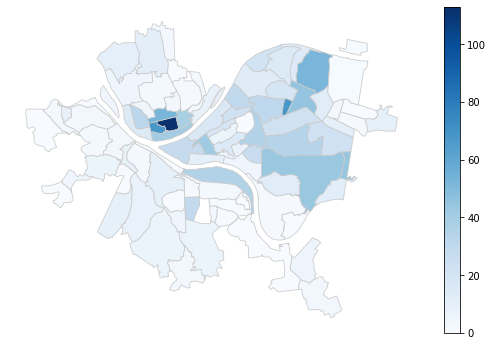

In [12]:
# Calculates The number of healthy trees per Square Kilometer
HTSK = (merged4['Tree Health']).div(merged4['SHAPE_Area'].mul(100000)).to_frame('Health of Trees per Square Kilometer')

# hey the final mergex variable. They grow up so fast.
merged5 = pd.concat([merged4, HTSK], axis=1, ignore_index=False, sort=False)

# more map variables. 
variable = 'Health of Trees per Square Kilometer'
vmin,vmax = 0, 113
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')

# There have been many legends carried down through these long few days. Legends that one day, the Healthy 
# trees may soon rise up and take their rightful place among the streets of Pittsburgh.
sm = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar = fig.colorbar(sm)

# The Final Map Creation :D
merged5.plot(column=variable, cmap='Blues', linewidth=0.8, vmin=vmin , vmax=vmax , ax=ax, edgecolor='0.8')

And now we finally have our winner. It goes to Alleghey Center! This neighborhood has proven to have not only the highest density of trees, but also the highest density of healthy tree too! We can finally crown the best Neighborhood in Pittsburgh based on these arbitrary measurements I have compounded together.

In [13]:
merged5[['neighborhood','Health of Trees per Square Kilometer']].sort_values(by='Health of Trees per Square Kilometer',ascending = False).head(10)

,neighborhood,Health of Trees per Square Kilometer
0,Allegheny Center,112.517340
33,Friendship,68.003125
1,Allegheny West,67.748393
18,Central Northside,53.190393
39,Highland Park,52.123281
28,East Liberty,45.457910
65,Regent Square,44.567335
76,Squirrel Hill South,43.628991
23,Crawford-Roberts,41.101303
56,North Shore,40.870919


As a bit of bonus information. I already shows one of the lists earlier, but heres the rest of the Worst neighborhoods for each category I tested above! So lets get right into it by starting with tree count!

In [14]:
merged[['neighborhood','count']].sort_values(by='count', ascending=True).head(10)

,neighborhood,count
37,Hays,1
70,South Shore,2
35,Glen Hazel,2
30,Esplen,3
4,Arlington Heights,5
57,Northview Heights,6
26,East Carnegie,8
77,St. Clair,12
53,Mt. Oliver,13
66,Ridgemont,31


Next we have the worst in tree density!

In [15]:
merged2[['neighborhood','Trees per Square Kilometer']].sort_values(by='Trees per Square Kilometer', ascending=True).head(10)

,neighborhood,Trees per Square Kilometer
37,Hays,0.020802
35,Glen Hazel,0.159603
70,South Shore,0.343528
30,Esplen,0.476494
26,East Carnegie,0.677856
57,Northview Heights,0.696739
31,Fairywood,1.167341
4,Arlington Heights,1.382913
77,St. Clair,1.409432
66,Ridgemont,3.068378


And finally, the worst of the worst when based on The density of healthy trees they have!